# BiteMe | Exploratory Data Analysis

In this notebook we analyse our images to help inform modelling.

In [33]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

In [3]:
# Define directories
base_dir_path = "../"

data_dir_path = os.path.join(base_dir_path, "data")
data_raw_dir_path = os.path.join(data_dir_path, "raw")
data_processed_dir_path = os.path.join(data_dir_path, "processed")

data_dir = os.listdir(data_dir_path)
data_raw_dir = os.listdir(data_raw_dir_path)

metadata_path = os.path.join(data_raw_dir_path, "metadata.csv")
metadata = pd.read_csv(metadata_path)

metadata.head()

,img_name,img_path,label
0,7059b14d2aa03ed6c4de11afa32591995181d31c.jpg,../data/raw/none/7059b14d2aa03ed6c4de11afa3259...,none
1,ea1b100b581fcdb7ddfae52cc62347a99e304ba4.jpg,../data/raw/none/ea1b100b581fcdb7ddfae52cc6234...,none
2,1a1442990ff143b7560e5757d9f76d37ab007f48.jpg,../data/raw/none/1a1442990ff143b7560e5757d9f76...,none
3,6eac051b9c45ff6821ec8675216f371711b7cea9.jpg,../data/raw/none/6eac051b9c45ff6821ec8675216f3...,none
4,fc72767f8520df9b2b83941077dc0ee013eb9399.jpg,../data/raw/none/fc72767f8520df9b2b83941077dc0...,none


In [4]:
metadata.value_counts("label")

label
tick        29
none        28
mosquito    28
horsefly    28
bedbug      28
ant         26
bee         25
mite        23
dtype: int64

In [5]:
print(f"Number of images: {len(metadata)}")

Number of images: 215


In [13]:
# Set image default dimensions
ROWS = 256
COLS = 256
CHANNELS = 3

SEED = 14

np.random.seed(SEED)
ia.seed(SEED)

In [20]:
def read_images(metadata_df, rows, cols, channels, rgb=False) -> np.array:
    """
    Takes in metadata dataframe and reads images to np.array
    
    Parameters
    ----------
    metadata_df : pd.Dataframe
        Metadata dataframe containing file paths.
        
    Returns
    -------
    np.array
        Multi-level array containing all images.    
    """
    
    img_list = []
    for img_path in metadata_df["img_path"]:
        # Read image in and resize
        img = cv2.imread(img_path)
        img = cv2.resize(img, (ROWS, COLS))
        
        if rgb:
            # Change from BGR to RGB
            img = img[...,::-1]
        
        # Append to list
        img_list.append(img)
        
    return np.array(img_list)

In [105]:
img_array = read_images(metadata, ROWS, COLS, CHANNELS, rgb=True)
print(f"Image array shape: {img_array.shape}")

Image array shape: (215, 256, 256, 3)


## Example Augmentations

In [179]:
# Get example image
example_img = np.expand_dims(img_array[65], axis=0)

In [180]:
def img_process(img: np.array=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    plt.figure()
    plt.imshow(img)

Example images


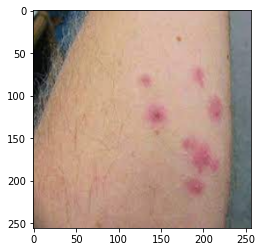

In [182]:
print("Example images")
for img in example_img:
    img_process(img)

Flip left to right


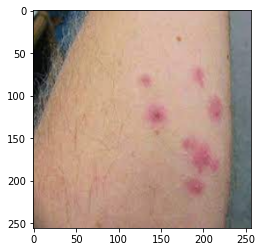

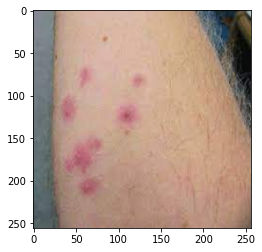

In [208]:
# Flip left to right
seq = iaa.Sequential([
    iaa.Fliplr(1)
])
images_aug = np.concatenate([example_img, seq(images=example_img)])
images_aug.shape

print("Flip left to right")
for img in images_aug:
    img_process(img)

In [ ]:
# Flip left to right
seq = iaa.Sequential([
    iaa.Fliplr(1)
])
images_aug = np.concatenate([example_img, seq(images=example_img)])
images_aug.shape

print("Flip left to right")
for img in images_aug:
    img_process(img)

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)